# № 5

Consider the local linear trend model:
$$
\begin{aligned}
y_t &= a_t + \epsilon_t^{y},
    && \epsilon_t^y\sim \mathcal{N}(0, \sigma_y) \\
a_t &= a_{t-1} + b_{t-1}+\epsilon_t^a,
    && \epsilon_t^a\sim \mathcal{N}(0, \sigma_a) \\
b_t &= b_{t-1}+\epsilon_t^b, 
    && \epsilon_t^b\sim \mathcal{N}(0, \sigma_b)
\end{aligned}
$$
with unknown parameters $\sigma_y$, $\sigma_b$. For the data in `10_5.pickle` [pickled numpy array with observed time series of $y_t$ and $\sigma_a$], compute, using the likelihood maximization (in spirit of Exercise 4), the most probable values of $\sigma_y$, $\sigma_b$. With these values, compute the smoothed trajectory of the local slope coefficient $b_t^{*}$ and plot it as a function of time. Compute the prediction for $y_{T+1}$ (that is for the time instant, following the latest available observation).

In [1]:
using PyCall

py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

data = py"load_pickle"("10_5.pickle")

Dict{Any, Any} with 2 entries:
  "sigma_a" => 0.1
  "y"       => [25.2041, -7.99118, 4.01155, 8.69083, 33.7176, 42.5471, -9.2547,…

In [2]:
σ_a = data["sigma_a"]
y = data["y"]
T = length(y)

500

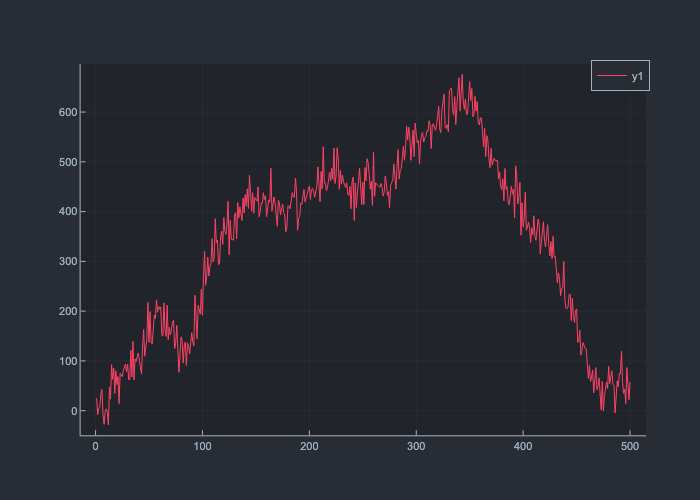

In [3]:
using Plots
plotlyjs()
theme(:juno)

plot(y)

Сделаем догадку о значениях $\sigma_y$ и $\sigma_b$:
$$
\begin{aligned}
y_t - y_{t-1}
&= a_{t-1} + b_{t-1} + \epsilon_t^a + \epsilon_t^y 
- (a_{t-1} + \epsilon_{t-1}^y) \\
&= b_{t-1} + \epsilon_t^a + \epsilon_t^y - \epsilon_{t-1}^y \\[1em]
%
(y_t - y_{t-1}) - (y_{t-1} - y_{t-2})
&= (b_{t-2} + \epsilon_{t-1}^b + \epsilon_t^a + \epsilon_t^y - \epsilon_{t-1}^y)
- (b_{t-2} + \epsilon_{t-1}^a + \epsilon_{t-1}^y - \epsilon_{t-2}^y) \\
&= \epsilon_{t-1}^b + \epsilon_t^a - \epsilon_{t-1}^a + \epsilon_t^y - 2\epsilon_{t-2}^y + \epsilon_{t-1}^y \\
&\sim \mathcal{N}(0, \sigma_b^2 + 2\sigma_a^2 + \sigma_y^2 + (2\sigma_y)^2 + \sigma_y^2) \\
&\sim \mathcal{N}(0, \sigma_b^2 + 2\sigma_a^2 + 6\sigma_y^2)
\end{aligned}
$$

In [4]:
using Statistics: cov

initial_guess = sqrt((cov(diff(diff(y))) - 2σ_a^2) / 7)

23.501733974557467

Совместное распределение вероятностей:
$$
\begin{aligned}
P(y, a, b) &=
\prod_{t=1}^T \frac{1}{\sqrt{2\pi} \sigma_y}\exp\left(-\frac{(y_t - a_t)^2}{2\sigma_y^2}\right)
\prod_{t=2}^T \frac{1}{\sqrt{2\pi} \sigma_a}\exp\left(-\frac{(a_t - a_{t-1} - b_{t-1})^2}{2\sigma_a^2}\right)
\prod_{t=2}^{T-1} \frac{1}{\sqrt{2\pi} \sigma_b}\exp\left(-\frac{(b_t - b_{t-1})^2}{2\sigma_b^2}\right) \\
%
&= \frac{1}{(2\pi)^{\frac32(T- 1)}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}}
\exp\left(
    -\frac{1}{2\sigma_y^2} \left(y^T y - 2 y^T a + a^T a\right)
    -\frac{1}{2\sigma_a^2} \left(a^T A a - 2 b^T D a + b^T b \right)
    -\frac{1}{2\sigma_b^2} \left(b^T \tilde A b \right)
\right)
\end{aligned}
$$
где
$$
A = \begin{pmatrix}
1 & -1 & 0 & \cdots & 0\\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1
\end{pmatrix}_{T\times T}
%
\tilde A = \begin{pmatrix}
1 & -1 & 0 & \cdots & 0\\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1
\end{pmatrix}_{(T-1) \times (T-1)}
%
D = \begin{pmatrix}
-1 & 1 & 0 & \cdots & 0 & 0\\
0 & -1 & 1 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -1 & 1
\end{pmatrix}_{(T-1) \times T}
$$

Мы знаем $y$ и $\sigma_a$.
Мы можем проинтегрировать по параметру $a$, который нас не интересует, и найти функцию правдоподобия для $b$, $\sigma_y$ и $\sigma_b$. Потом мы сможем её максимизировать и найти наиболее вероятные $b$, $\sigma_y$ и $\sigma_b$.

Но в задании просят использовать двухступенчатый подход. 
1. Сначала мы вычислим $\int P da\, db$ и найдём функцию правдоподобия для $\sigma_y$ и $\sigma_b$. Потом мы максимизируем её и найдём наиболее вероятные $\sigma_y$ и $\sigma_b$.

2. Потом мы зафиксируем $\sigma_y, \sigma_b$, вычислим $\int P da$ и найдём функцию правдоподобия / распределение вероятностей для $b$. Потом мы максимизируем её и найдём наиболее вероятные $b$.

Обозначим $s_{y,a,b} = \sigma_{y,a,b}^{-2}$ и приступим к вычислению гауссовских интегралов, используя формулу
$$
\int \exp\left(-\frac{1}{2} x^T A x + b^T x\right) dx = \sqrt{\frac{(2\pi)^n}{\det A}} \exp\left(\frac{1}{2} b^T A^{-1} b\right)
$$

Для удобства интегрирования сначала сделаем пункт 2.
$$
\begin{aligned}
P(y, b) &= \int P(y, a, b) da \\
&= \frac{1}{(2\pi)^{\frac32(T- 1)}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}}
\int \exp\left(
    -\frac12 a^T \left(s_y \hat 1 + s_a A \right) a
    + \left(s_a b^T D + s_y y^T\right) a
    -\frac12 b^T \left(s_a \hat 1 + s_b \tilde A\right) b
    -\frac{s_y}{2} y^T y
\right) da &\\
&= \frac{1}{(2\pi)^{T - 3/2}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}} \frac{1}{\sqrt{\det\left(s_y \hat 1 + s_a A \right)}} \cdot \\
&\phantom{=} \cdot \exp\left(
    \frac12 \left(s_a b^T D + s_y y^T\right) \left(s_y \hat 1 + s_a A \right)^{-1} \left(s_a b^T D + s_y y^T\right)^T
    -\frac12 b^T \left(s_a \hat 1 + s_b \tilde A\right) b
    -\frac{s_y}{2} y^T y
\right) \\
&= \frac{1}{(2\pi)^{T - 3/2}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}} \frac{1}{\sqrt{\det\left(s_y \hat 1 + s_a A \right)}} \cdot \\
&\phantom{=} \cdot \exp\left(
    -\frac12 b^T \left(
        s_a \hat 1 + s_b \tilde A - s_a^2 D (s_y \hat 1 + s_a A )^{-1} D^T
    \right) b
    + b^T s_a s_y D (s_y \hat 1 + s_a A )^{-1} y^T
    - \frac12 y^T \Bigl(s_y \hat 1 - s_y^2 (s_y \hat 1 + s_a A )^{-1}\Bigr) y
\right) \\
&= \frac{1}{(2\pi)^{T - 3/2}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}} \frac{1}{\sqrt{\det Q_a}}
\exp\left(
    -\frac12 b^T Q_b b
    + b^T \tilde \mu_b
    - \frac12 y^T Q_y y
\right)
\end{aligned}
$$
где введены обозначения 
$$
\begin{aligned}
Q_a &= s_y \hat 1 + s_a A \\
Q_b &= s_a \hat 1 + s_b \tilde A - s_a^2 D Q_a^{-1} D^T \\
Q_y &= s_y \hat 1 - s_y^2 Q_a^{-1} \\
\tilde \mu_b &= s_a s_y D Q_a^{-1} y^T
\end{aligned}
$$

В терминах $b$, это нормальное распределение с матрицей ковариаций $Q_b^{-1}$ и средним $\mu_b = Q_b^{-1} \tilde \mu_b$.

Получим теперь функцию правдоподобия для $\sigma_y, \sigma_b$:
$$
\begin{aligned}
L(\sigma_y, \sigma_b) &= \int P(y, a, b) da\, db = \int P(y, b) db \\
&= \frac{1}{(2\pi)^{T - 3/2}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}} \frac{1}{\sqrt{\det Q_a}}
\int \exp\left(
    -\frac12 b^T Q_b b
    + b^T \tilde \mu_b
    - \frac12 y^T Q_y y
\right) db \\
& = \frac{1}{(2\pi)^{T/2 - 1}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}} \frac{1}{\sqrt{\det Q_a}} \frac{1}{\sqrt{\det Q_b}}
\exp\left(
    \frac12 \tilde \mu_b^T Q_b^{-1} \tilde \mu_b
    - \frac12 y^T Q_y y
\right)
\end{aligned}
$$

Её удвоенный логарифм:
$$
2 \ln L(\sigma_y, \sigma_b) = T \ln s_y + (T-1) \ln s_a + (T-2) \ln s_b - \ln \det Q_a - \ln \det Q_b + \tilde \mu_b^T Q_b^{-1} \tilde \mu_b - y^T Q_y y + \text{const}
$$

In [5]:
using LinearAlgebra

function A(T)
    main_diagonal = 2ones(T)
    main_diagonal[1] = 1
    main_diagonal[end] = 1

    sub_diagonal = -ones(T-1)

    return SymTridiagonal(main_diagonal, sub_diagonal)
end

A (generic function with 1 method)

In [6]:
using BandedMatrices

function D(T)
    first_diagonal = -ones(T-1)
    second_diagonal = ones(T-1)

    return BandedMatrix((0 => first_diagonal, 1 => second_diagonal), (T-1, T))
end

D(4)

3×4 BandedMatrix{Float64} with bandwidths (0, 1):
 -1.0   1.0    ⋅    ⋅ 
   ⋅   -1.0   1.0   ⋅ 
   ⋅     ⋅   -1.0  1.0

In [7]:
function Q_a(s_a, s_y, T)
    return s_y * I + s_a * A(T)
end

function Q_b(s_a, s_b, s_y, T)
    D_ = D(T)
    Ã = A(T-1)
    Q_a_ = Q_a(s_a, s_y, T)
    return s_a * I + s_b * Ã - s_a^2 * D_ * (Q_a_ \ D_')
end

function Q_y_form(s_a, s_y, y) # y'*Q_y*y in O(T)
    T = length(y)
    Q_a_ = Q_a(s_a, s_y, T)
    return (
        s_y * y' * y
        - s_y^2 * y' * (Q_a_ \ y)
    )
end

function μ̃_b(s_a, s_b, s_y, y)
    T = length(y)
    return s_a * s_y * D(T) * (Q_a(s_a, s_y, T) \ y)
end

μ̃_b (generic function with 1 method)

In [8]:
function log_likelihood_times2(s_a, s_b, s_y, y)
    T = length(y)
    Q_a_ = Q_a(s_a, s_y, T)
    Q_b_ = Q_b(s_a, s_b, s_y, T)
    μ̃_b_ = μ̃_b(s_a, s_b, s_y, y)
    return (
        T*log(s_y) + (T-1)*log(s_a) + (T-2)*log(s_b)
        - logdet(Q_a_) - logdet(Q_b_)
        + μ̃_b_' * (Q_b_ \ μ̃_b_)
        - Q_y_form(s_a, s_y, y)
    )
end

log_likelihood_times2 (generic function with 1 method)

Построим график функции, которую собираемся максимизировать, и убедимся, что у неё есть максимум.

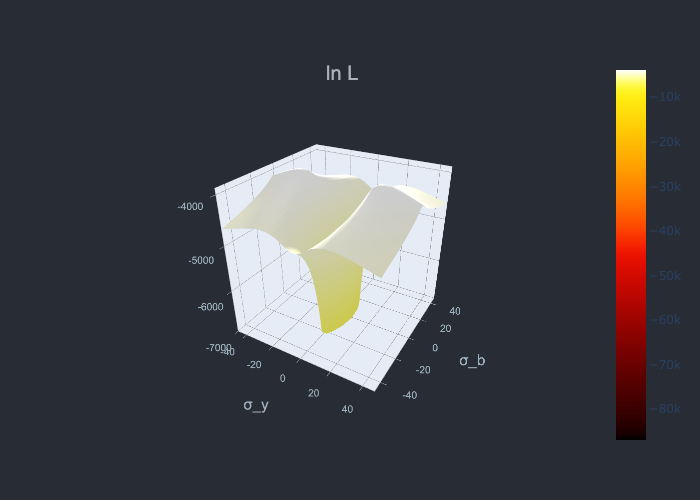

In [9]:
using Plots

plot(
    range(-2initial_guess, 2initial_guess, length=32),
    range(-2initial_guess, 2initial_guess, length=32),
    (σ_y, σ_b) -> log_likelihood_times2(1/σ_a^2, 1/σ_b^2, 1/σ_y^2, y),
    st = :surface,
    zlims = (-7e3, Inf),
    title = "ln L",
    xlabel = "σ_y",
    ylabel = "σ_b",
)

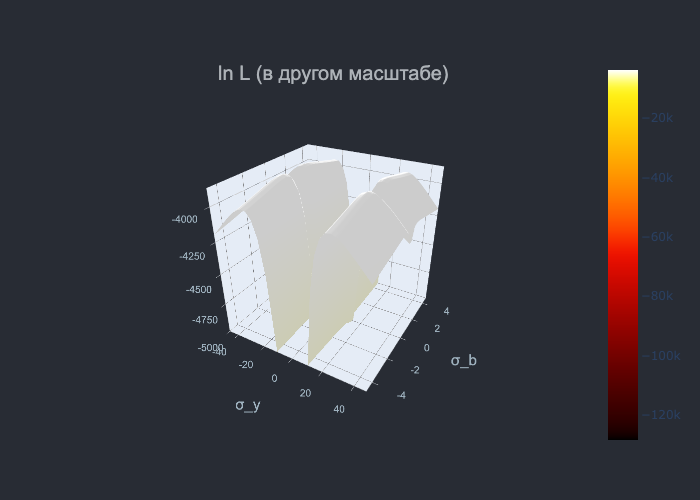

In [10]:
using Plots

plot(
    range(-2initial_guess, 2initial_guess, length=32),
    range(-0.2initial_guess, 0.2initial_guess, length=32),
    (σ_y, σ_b) -> log_likelihood_times2(1/σ_a^2, 1/σ_b^2, 1/σ_y^2, y),
    st = :surface,
    zlims = (-5e3, Inf),
    title = "ln L (в другом масштабе)",
    xlabel = "σ_y",
    ylabel = "σ_b",
)

Максимумов 4, как и должно быть, поскольку $L$ не меняется при замене $\sigma_y \leftrightarrow -\sigma_y$ и $\sigma_b \leftrightarrow -\sigma_b$.

In [11]:
using Optim

res = optimize(
    p -> -log_likelihood_times2(1/σ_a^2, 1/p[1]^2, 1/p[2]^2, y),
    [initial_guess, initial_guess],
    autodiff = :forward,
)

 * Status: success

 * Candidate solution
    Final objective value:     3.875991e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    82
    f(x) calls:    208


In [12]:
σ_b_est, σ_y_est = res.minimizer

2-element Vector{Float64}:
 -1.1016604486596677
 25.52272577365003

Выше мы получили, что при фиксированных $\sigma_a, \sigma_b, \sigma_y, y$ вектор $b$ распределен нормально c матрицей ковариаций $Q_b^{-1}$ и средним $\mu_b = Q_b^{-1} \tilde \mu_b$.

Теперь, зная оптимальные $\sigma_b, \sigma_y$, мы можем вычислить $\mu_b$:

In [13]:
s_b_est, s_y_est = res.minimizer.^-2
s_a = σ_a^-2

100.0

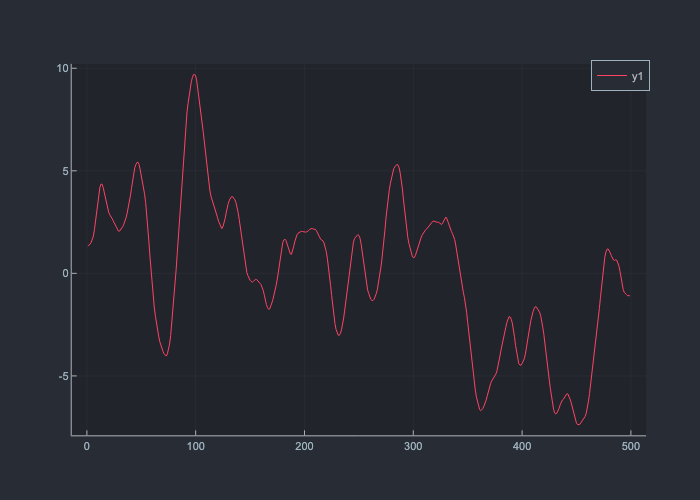

In [14]:
b_est = Q_b(s_a, s_b_est, s_y_est, T) \ μ̃_b(s_a, s_b_est, s_y_est, y)

plot(b_est)

Получим отфильтрованную траекторию. Вспомним, что
$$
\begin{aligned}
P(y, a, b) = \frac{1}{(2\pi)^{\frac32(T-1)}} \frac{1}{\sigma_y^T \sigma_a^{T-1} \sigma_b^{T-2}}
\exp\left(
    -\frac12 a^T \left(s_y \hat 1 + s_a A \right) a
    + \left(s_a b^T D + s_y y^T\right) a
    -\frac12 b^T \left(s_a \hat 1 + s_b \tilde A\right) b
    -\frac{s_y}{2} y^T y
\right)
\end{aligned}
$$
Если зафиксировать $b, \sigma_b, \sigma_y$ (у нас уже есть для них оценки), то получится нормальное распределение с матрицей ковариаций $Q_a^{-1} = \left(s_y \hat 1 + s_a A \right)^{-1}$ и средним $\mu_a = Q_a^{-1} \left(s_a b^T D + s_y y^T\right)^T$.

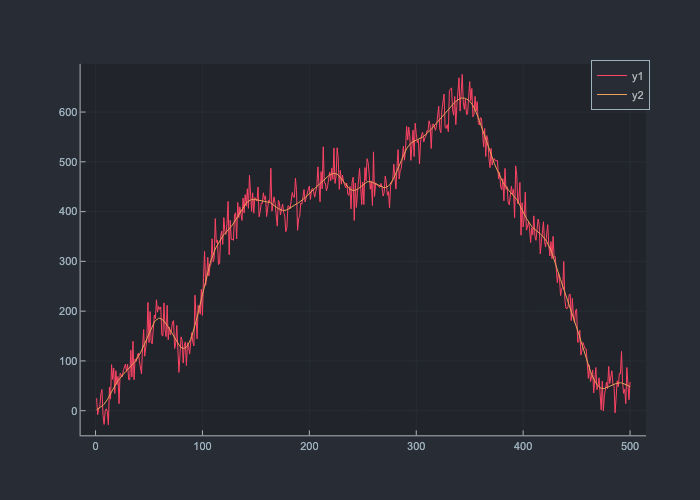

In [15]:
a_est = Q_a(s_a, s_y_est, T) \ (s_a * b_est' * D(T) + s_y_est * y')'

plot([y a_est])

Альтернативно, с точностью до сдвига, `a_est = cumsum(b_est)`.

Осталось предсказать, чему равно $y_{T+1}$:
$$
E[y_{T+1}] = E[a_{T+1}] = E[a_T] + E[b_T] = E[a_T] + E[b_{T-1}]
$$

In [16]:
# y_{T+1}
a_est[end] + b_est[end]

47.19609999056121